# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==0.23.0 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FL GMP

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/liver/data/fetal_liver_alladata_Copy1.h5ad')

In [4]:
adata.raw = adata

In [5]:
adata.obs["tissue"] = "liver"

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
B cell                            1079
DC1                                336
DC2                               3954
DC precursor                       330
Early Erythroid                  11985
Early lymphoid_T lymphocyte        767
Endothelial cell                  3348
Fibroblast                        1713
HSC_MPP                           3439
Hepatocyte                        2479
ILC precursor                     1726
Kupffer Cell                     24841
Late Erythroid                    3180
MEMP                              1342
Mast cell                         1308
Megakaryocyte                     3983
Mid Erythroid                    27000
Mono-Mac                          6590
Monocyte                          2586
Monocyte precursor                 350
NK                                6706
Neutrophil-myeloid progenitor      658
Pre pro B cell                     234
VCAM1+ EI macrophage               161
pDC precursor                      253
pre-B cell   

In [7]:
cell_numbers = adata.obs.groupby(['cell.labels_progen']).apply(len)
cell_numbers

cell.labels_progen
ELP                        525
GMP                        362
HSC                        242
MEMP                       505
MEP                        639
MPP                       2012
early MK                    81
early erythroid            333
eo/baso/mast precursor      86
erythroid-MPP hybrid        14
macrophage                  81
myeloid DC progenitor       94
pDC progenitor              41
dtype: int64

In [8]:
adata = adata[adata.obs['cell.labels_progen'].isin(['GMP'])].copy()

In [9]:
cell_numbers = adata.obs.groupby(['cell.labels_progen']).apply(len)
cell_numbers

cell.labels_progen
GMP    362
dtype: int64

In [10]:
adata.obs["cell.labels"] = "GMP"

In [11]:
adata.obs["tissue"] = "liver"
adata.obs["tissue_cell.labels"] = adata.obs["tissue"].astype(str) + '_' + adata.obs["cell.labels"].astype(str)

In [12]:
cell_numbers = adata.obs.groupby(["tissue_cell.labels"]).apply(len)
cell_numbers

tissue_cell.labels
liver_GMP    362
dtype: int64

In [13]:
liver = adata

# Load FBM GMP

In [14]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20201007.h5ad')

In [15]:
adata.raw = adata

In [16]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   327
CD8 T cell                   171
CD14 monocyte               8763
CD56 bright NK               449
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1357
GMP                         1281
HSC                           92
ILC precursor                 67
LMPP                          34
MEMP                          16
MEP                          269
MK                          1000
MOP                         3838
MPP myeloid                   92
NK T cell                    111
NK progenitor                 26
Treg                          62
adipo-CAR                    353
arteriolar fibroblast         83
basophil                     139
chondrocyte                   80
early MK                    1624
early erythroid             7474
early osteoblast             280
endosteal fibroblast          5

In [17]:
adata.obs["tissue"] = "fbm"

In [18]:
adata = adata[adata.obs['cell.labels'].isin(['GMP'])].copy()

In [19]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
GMP    1281
dtype: int64

In [20]:
adata.obs["tissue"] = "fbm"
adata.obs["tissue_cell.labels"] = adata.obs["tissue"].astype(str) + '_' + adata.obs["cell.labels"].astype(str)

In [21]:
cell_numbers = adata.obs.groupby(["tissue_cell.labels"]).apply(len)
cell_numbers

tissue_cell.labels
fbm_GMP    1281
dtype: int64

In [22]:
fbm = adata

# Merge the GMP datasets

In [23]:
merged = liver.concatenate(fbm, index_unique=None, join='outer')

In [24]:
merged.shape

(1643, 33713)

In [25]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
cell_numbers = merged.obs.groupby(["tissue_cell.labels"]).apply(len)
cell_numbers

tissue_cell.labels
fbm_GMP      1281
liver_GMP     362
dtype: int64

In [26]:
merged

AnnData object with n_obs × n_vars = 1643 × 33713 
    obs: 'AnnatomicalPart', 'april_cell.labels', 'batch', 'cell.labels', 'cell.labels_20200708', 'cell.labels_20200713', 'cell.labels_20200718', 'cell.labels_progen', 'combined.labels', 'doublets', 'fetal.ids', 'gender', 'is_doublet', 'is_doublet_poptrim', 'is_doublet_wolock', 'lanes', 'mito.threshold', 'nGene', 'nUMI', 'n_counts', 'nk_meta', 'orig.ident', 'percent.mito', 'processing.type', 'sample', 'sample.type', 'scrublet_cluster_score', 'scrublet_score', 'sequencing.type', 'sort.ids', 'stages', 'tissue', 'tissue_cell.labels'
    var: 'gene_ids-1-1', 'feature_types-1-1'
    obsm: 'X_umap'

# Pre-process the datasets (no dimensional reduction)

In [27]:
adata = merged

In [28]:
adata.shape

(1643, 33713)

In [29]:
adata.X

<1643x33713 sparse matrix of type '<class 'numpy.float32'>'
	with 5949786 stored elements in Compressed Sparse Row format>

In [30]:
adata.X = np.nan_to_num(adata.X, copy=False)

In [31]:
adata.X

<1643x33713 sparse matrix of type '<class 'numpy.float32'>'
	with 5949786 stored elements in Compressed Sparse Row format>

In [32]:
# have a look at raw GEX values
#adata.X.toarray()

In [33]:
# Add 0.01 to all raw values to ensure that ratio can be run for cells with zero expression of one TF
#adata.X = adata.X.toarray() + 0.01
#adata.X

In [34]:
# normalise count data 
sc.pp.normalize_total(adata)

In [35]:
# log the count data 
sc.pp.log1p(adata)

In [36]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [37]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [38]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
#adata.X = np.where(adata.X < 0, 0.01, adata.X)
adata.X = np.where(adata.X < 0, 0, adata.X)

# Save the transformed GEX for SPIB/CEBPA along with tissue and sample

In [39]:
metadata_df = pd.DataFrame(adata.obs[["tissue_cell.labels", "orig.ident"]])
metadata_df

,tissue_cell.labels,orig.ident
index,,
F45_liver_CD45-_FCAImmP7579223_CGTAGCGAGTACCGGA,liver_GMP,F45
F30_liver_CD45-_FCAImmP7277561_CTTAACTGTCGCGGTT,liver_GMP,F30
F34_liver_CD45-_FCAImmP7352195_CACACTCAGCTAGCCC,liver_GMP,F34
F45_liver_CD45+_FCAImmP7579210_GAACCTACAGTATCTG,liver_GMP,F45
F45_liver_CD45-_FCAImmP7579223_ACTGAACTCAGAGGTG,liver_GMP,F45
F45_liver_CD45-_FCAImmP7579223_TTTGTCAAGTATCTCG,liver_GMP,F45
F21_liver_CD45-_FCAImmP7179364_ACAGCCGCACAGACAG,liver_GMP,F21
F21_liver_CD45-_FCAImmP7179364_AGGGAGTGTAGAGGAA,liver_GMP,F21
F21_liver_CD45-_FCAImmP7179364_GGATGTTCACACATGT,liver_GMP,F21


In [40]:
gex_df = pd.DataFrame(data=adata.X, index=adata.obs.index, columns=adata.var.index)
gex_df = gex_df[['SPI1','CEBPA']]
gex_df

,SPI1,CEBPA
index,,
F45_liver_CD45-_FCAImmP7579223_CGTAGCGAGTACCGGA,0.000000,0.000000
F30_liver_CD45-_FCAImmP7277561_CTTAACTGTCGCGGTT,0.299145,0.000000
F34_liver_CD45-_FCAImmP7352195_CACACTCAGCTAGCCC,1.111419,0.000000
F45_liver_CD45+_FCAImmP7579210_GAACCTACAGTATCTG,0.000000,0.673389
F45_liver_CD45-_FCAImmP7579223_ACTGAACTCAGAGGTG,0.000000,0.000000
F45_liver_CD45-_FCAImmP7579223_TTTGTCAAGTATCTCG,0.000000,0.000000
F21_liver_CD45-_FCAImmP7179364_ACAGCCGCACAGACAG,0.000000,0.000000
F21_liver_CD45-_FCAImmP7179364_AGGGAGTGTAGAGGAA,0.000000,0.853611
F21_liver_CD45-_FCAImmP7179364_GGATGTTCACACATGT,0.000000,0.313868


In [41]:
merged_df = gex_df.merge(metadata_df, left_index=True, right_index=True)
merged_df.to_csv('/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/gmp_spi1_cebpa_expression_fl_fbm_20210216.csv')
merged_df

,SPI1,CEBPA,tissue_cell.labels,orig.ident
index,,,,
F45_liver_CD45-_FCAImmP7579223_CGTAGCGAGTACCGGA,0.000000,0.000000,liver_GMP,F45
F30_liver_CD45-_FCAImmP7277561_CTTAACTGTCGCGGTT,0.299145,0.000000,liver_GMP,F30
F34_liver_CD45-_FCAImmP7352195_CACACTCAGCTAGCCC,1.111419,0.000000,liver_GMP,F34
F45_liver_CD45+_FCAImmP7579210_GAACCTACAGTATCTG,0.000000,0.673389,liver_GMP,F45
F45_liver_CD45-_FCAImmP7579223_ACTGAACTCAGAGGTG,0.000000,0.000000,liver_GMP,F45
F45_liver_CD45-_FCAImmP7579223_TTTGTCAAGTATCTCG,0.000000,0.000000,liver_GMP,F45
F21_liver_CD45-_FCAImmP7179364_ACAGCCGCACAGACAG,0.000000,0.000000,liver_GMP,F21
F21_liver_CD45-_FCAImmP7179364_AGGGAGTGTAGAGGAA,0.000000,0.853611,liver_GMP,F21
F21_liver_CD45-_FCAImmP7179364_GGATGTTCACACATGT,0.000000,0.313868,liver_GMP,F21


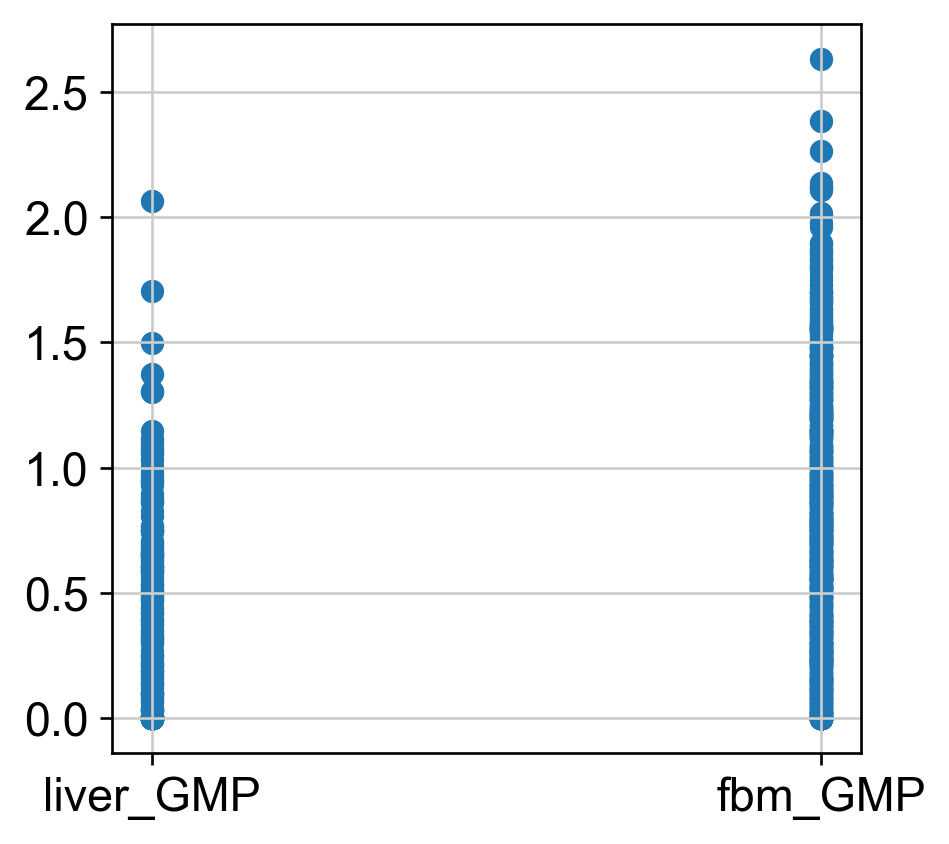

In [42]:
plt.scatter(merged_df["tissue_cell.labels"] ,merged_df["SPI1"])

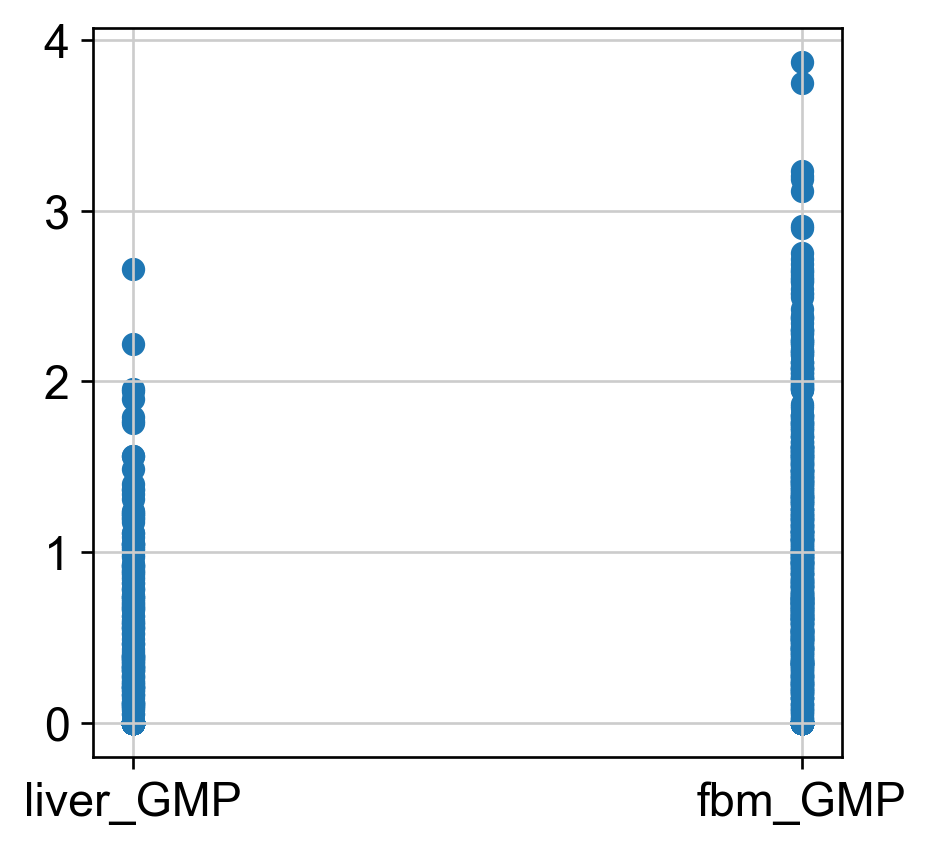

In [43]:
plt.scatter(merged_df["tissue_cell.labels"] ,merged_df["CEBPA"])

# Save the data

In [44]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [45]:
adata.X

<1643x33713 sparse matrix of type '<class 'numpy.float32'>'
	with 5132441 stored elements in Compressed Sparse Row format>

In [46]:
adata.raw.X

<1643x33713 sparse matrix of type '<class 'numpy.float32'>'
	with 5949786 stored elements in Compressed Sparse Row format>

In [47]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/fig2c_gmp_spi1_cebpa_20210216.h5ad")

... storing 'AnnatomicalPart' as categorical
... storing 'april_cell.labels' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'cell.labels_progen' as categorical
... storing 'combined.labels' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'mito.threshold' as categorical
... storing 'nk_meta' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sample' as categorical
... storing 'sample.type' as categorical
... storing 'sequencing.type' as categorical
... storing 'sort.ids' as categorical
... storing 'st